In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import shutil
!pip install faiss-gpu
!pip install faiss-cpu 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
start_time = time.time()

os.chdir('/content')

if  not os.path.isfile('/content/small/train/37.70/@0544204.32@4173406.33@10@S@037.70683@-122.49851@TYcjxIohRl--XFaR4OgdxA@@0@@@@201910@@.jpg'):
  print('data will be extracted in :' ,os.getcwd()) 
  !unzip -q '/content/drive/MyDrive/Class_Vis_Geo/datasets/sf-xs.zip'

  print(time.time() - start_time  )



# exploring


In [ ]:
os.chdir('/content/drive/MyDrive/Class_Vis_Geo/CosPlace_post_rerank')
import faiss
import torch
import logging
import numpy as np
from tqdm import tqdm
from typing import Tuple
from argparse import Namespace
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader, Dataset
from model import network
model = network.GeoLocalizationNet('resnet18', 512)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model = model.eval()

from datasets.test_dataset import TestDataset
test_ds = TestDataset('/content/small/test', queries_folder="queries_v1", positive_dist_threshold=25)

RECALL_VALUES = [1, 5, 10, 20]

with torch.no_grad():
    # logging.debug("Extracting database descriptors for evaluation/testing")
    database_subset_ds = Subset(test_ds , list(range(test_ds.database_num)))
    database_dataloader = DataLoader(dataset=database_subset_ds, num_workers=2,
                                      batch_size=16, pin_memory=(device == "cuda"))
    all_descriptors = np.empty((len(test_ds), 512), dtype="float32")

    for images, indices in tqdm(database_dataloader, ncols=100):

       
        descriptors = model(images.to(device))
        descriptors = descriptors.cpu().numpy()
        all_descriptors[indices.numpy(), :] = descriptors
    
    # logging.debug("Extracting queries descriptors for evaluation/testing using batch size 1")
    queries_infer_batch_size = 1
    queries_subset_ds = Subset(test_ds, list(range(test_ds.database_num, test_ds.database_num+test_ds.queries_num)))
    queries_dataloader = DataLoader(dataset=queries_subset_ds, num_workers=2,
                                    batch_size=queries_infer_batch_size, pin_memory=(device == "cuda"))
    for images, indices in tqdm(queries_dataloader, ncols=100):
        descriptors = model(images.to(device))
        descriptors = descriptors.cpu().numpy()
        all_descriptors[indices.numpy(), :] = descriptors
queries_descriptors = all_descriptors[test_ds.database_num:]
database_descriptors = all_descriptors[:test_ds.database_num]

# Use a kNN to find predictions
post_processing = 're_ranking'
faiss_index = faiss.IndexFlatL2(512)
faiss_index.add(database_descriptors)
print(type(faiss_index))
del database_descriptors, all_descriptors


_, predictions = faiss_index.search(queries_descriptors, max(RECALL_VALUES))

positives_per_query = test_ds.get_positives()
database_utm = test_ds.get_database_utm()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|███████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.54it/s]


<class 'faiss.swigfaiss_avx2.IndexFlatL2'>


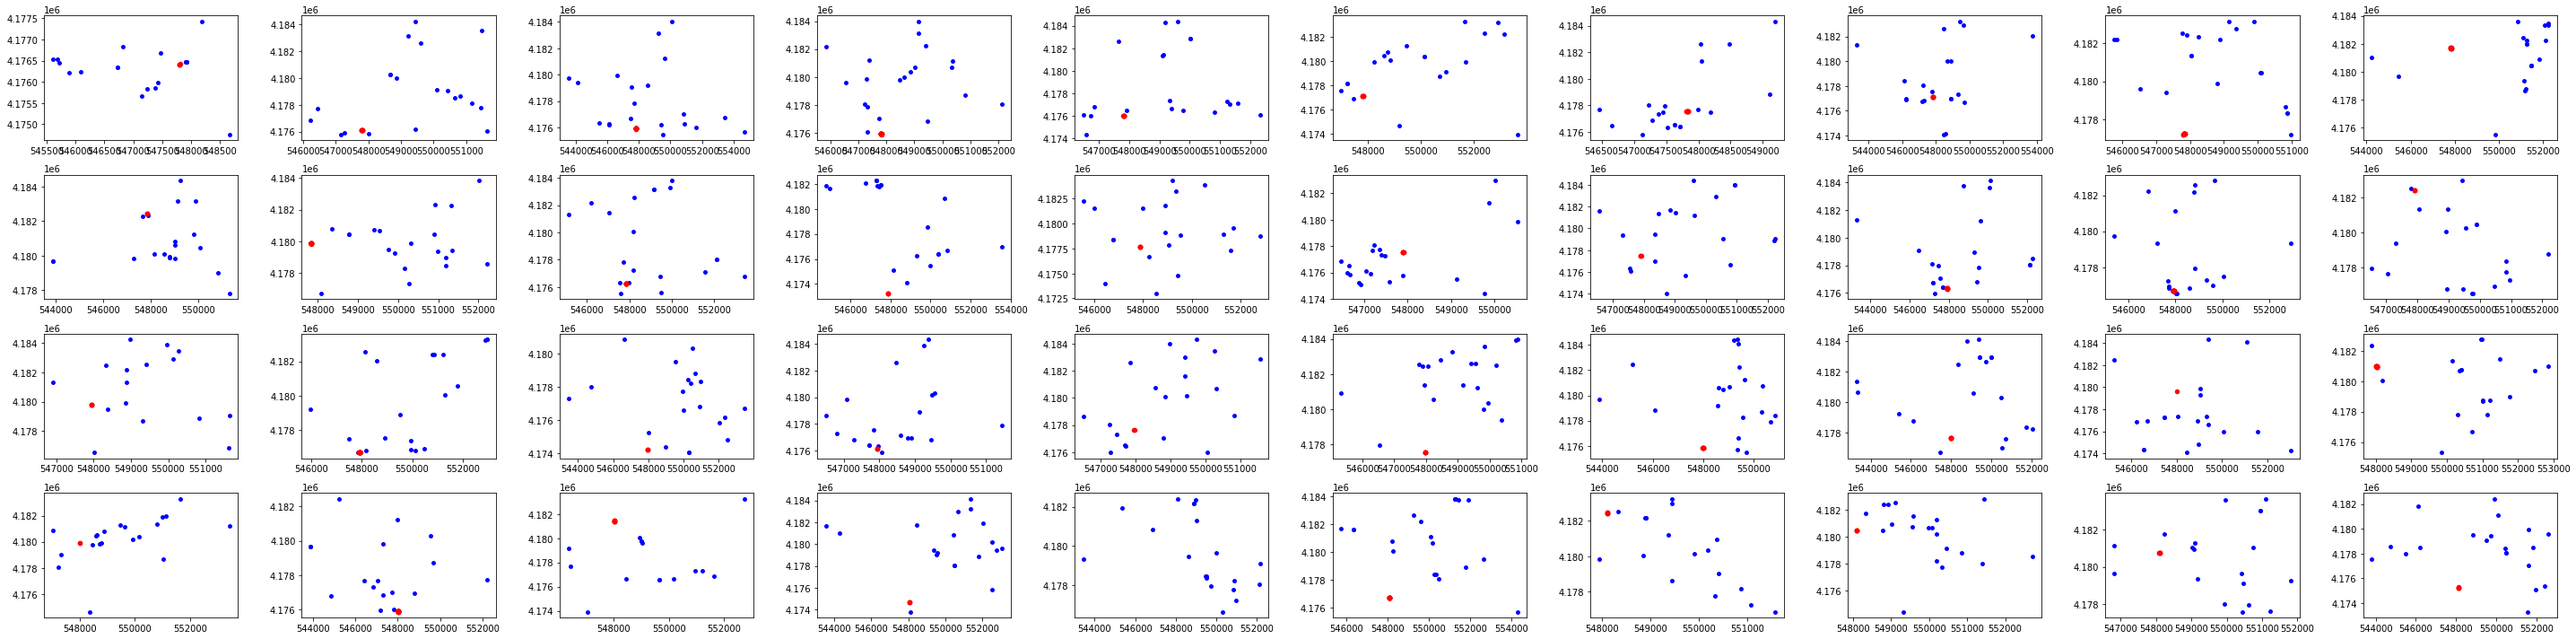

In [ ]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(4,10,figsize=(40,10))
c=1
for i in range(200,240):  
  preds =   predictions[i]
  plt.tight_layout()
  preds_data = database_utm[preds]
  pos_data = database_utm[positives_per_query[i]]
  plt.subplot(4,10, c)   
  plt.scatter(preds_data[:, 0],preds_data[:, 1],s=15,c='b')
  plt.scatter(pos_data[:, 0],pos_data[:, 1],s=20,c='r')
  c+=1


In [ ]:
from sklearn.cluster import DBSCAN
def re_ranking(preds,database_utm,distance,min_per,N):
    re_ranked = False
    preds =preds[:N]
    pred_utm1  = database_utm[preds]
    clustering1 = DBSCAN(eps=distance, min_samples=2).fit(pred_utm1)
    
    labels1 =  clustering1.labels_ 
    print( labels1 )

    available_groups = set( labels1) -{-1}
    for group_ in  available_groups:
      group_size = np.count_nonzero(labels1 ==group_)
      if group_size > min_per* len(preds):
       
        indices =  np.where(labels1 == group_)[0]
        pred_1_0 = preds[indices]
        pred_1_1 =  np.delete(preds, indices)
        pred_new = np.concatenate(( pred_1_0,pred_1_1))
        re_ranked = True   

    if (re_ranked==False):
          pred_new = preds

    return(pred_new)



def remove_reduntant(preds,database_utm,distance,N,print_ =False):
    preds = preds[:N]
    pred_utm1  = database_utm[preds]
    clustering1 = DBSCAN(eps=distance, min_samples=2).fit(pred_utm1)
    labels1 =  clustering1.labels_ 
    available_groups = set( labels1) -{-1}
   
    pred_new =np.copy(preds) 
    for group_ in  available_groups:
      indices =  np.where(labels1 == group_)[0]
     
      indices.sort()
      indices = indices[::-1]
      if len(indices) >1:  

        for ind in indices[1:]: 
                  if len(pred_new)> N:        
                    pred_new =  np.delete(pred_new,ind )          
                  if print_:
                        print('#############deleted##############')                        
                        print(ind)                         
                        print(pred_new )  
    return(pred_new)

In [ ]:
Rec ={}
for R_i in range(1,11):
      Rec['recalls'+str(R_i)] = np.zeros(len(RECALL_VALUES))
query_index = 250
preds =   predictions[query_index]

# for query_index, preds in enumerate(predictions):
check ={}
for mm in range(1,11):
          check[mm]= True
for i, n in enumerate(RECALL_VALUES):
  ####################### re ranking ###################################### 
    preds1 = re_ranking(preds,database_utm,100,min_per= 0.5,N=n)
    print('N',n)
    print('preds1',preds1)
    if np.any(np.in1d(preds1[:n], positives_per_query[query_index])):
        if check[1]:
            Rec['recalls1'][i:] += 1
            check[1] = False

    preds11 = remove_reduntant(preds,database_utm,10000,N=n)
    print('preds11',preds11)




print('********************')
print('preds',preds)



[-1]
N 1
preds1 [14852]
preds11 [14852]
[-1 -1  0  0 -1]
N 5
preds1 [14852 19807 22148 22151 15908]
preds11 [15908]
[-1 -1  0  0 -1 -1 -1 -1 -1 -1]
N 10
preds1 [14852 19807 22148 22151 15908  3012  1439  5859  2115 11694]
preds11 [11694]
[ 0 -1  1  1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1  0 -1 -1 -1 -1  2]
N 20
preds1 [14852 19807 22148 22151 15908  3012  1439  5859  2115 11694 15700  7690
 19283 13572 14868 14227 13761  6674 11397 11703]
preds11 [11703]
********************
preds [14852 19807 22148 22151 15908  3012  1439  5859  2115 11694 15700  7690
 19283 13572 14868 14227 13761  6674 11397 11703]


# Test with Re_rank  and post process

# sanf

In [ ]:
os.chdir('/content/drive/MyDrive/Class_Vis_Geo/CosPlace_post_rerank') 
!python eval.py --dataset_folder /content/small --groups_num 1  \
--resume_model /content/drive/MyDrive/Class_Vis_Geo/CosPlace/logs/cos_place_epoch10/2023-01-12_11-37-00/best_model.pth\
--save_dir re_rank


2023-01-24 21:43:16   eval.py --dataset_folder /content/small --groups_num 1 --resume_model /content/drive/MyDrive/Class_Vis_Geo/CosPlace/logs/cos_place_epoch10/2023-01-12_11-37-00/best_model.pth --save_dir re_rank
2023-01-24 21:43:16   Arguments: Namespace(L=2, M=10, N=5, alpha=30, augmentation_device='cuda', backbone='resnet18', batch_size=32, brightness=0.7, classifiers_lr=0.01, contrast=0.7, dataset_folder='/content/small', device='cuda', epochs_num=50, fc_output_dim=512, groups_num=1, hue=0.5, infer_batch_size=16, iterations_per_epoch=10000, lr=1e-05, min_images_per_class=10, num_workers=8, positive_dist_threshold=25, random_resized_crop=0.5, resume_model='/content/drive/MyDrive/Class_Vis_Geo/CosPlace/logs/cos_place_epoch10/2023-01-12_11-37-00/best_model.pth', resume_train=None, saturation=0.7, save_dir='re_rank', seed=0, test_set_folder='/content/small/test', use_amp16=False)
2023-01-24 21:43:16   The outputs are being saved in logs/re_rank/2023-01-24_21-43-16
/usr/local/lib/pyth

## tokyo xs

In [ ]:
os.chdir('/content')

if  not os.path.isfile('/content/tokyo_xs/test/queries/@0381523.71@3946790.15@54@S@035.65786@0139.69112@00685.jpg@@@@@@@@.jpg'):
  print('data will be extracted in :' ,os.getcwd()) 
  !unzip -q '/content/drive/MyDrive/Class_Vis_Geo/datasets/tokyo-xs.zip'

os.chdir("/content/tokyo_xs/test") 
os.rename("queries","queries_v1")


data will be extracted in : /content
replace tokyo_xs/test/database/@0382220.65@3946742.50@54@S@035.65751@0139.69883@_k8O5Z8sU3zZ2png78relg@00@@@@@@@.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

OSError: ignored

In [ ]:
os.chdir('/content/drive/MyDrive/Class_Vis_Geo/CosPlace_post_rerank') 

! python3 eval.py --dataset_folder /content/tokyo_xs --backbone resnet18 \
 --fc_output_dim 512 --resume_model /content/drive/MyDrive/Class_Vis_Geo/CosPlace/logs/default/2022-12-30_05-54-55/best_model.pth\
 --save_dir re_rank/tokyo

2023-01-24 21:51:46   eval.py --dataset_folder /content/tokyo_xs --backbone resnet18 --fc_output_dim 512 --resume_model /content/drive/MyDrive/Class_Vis_Geo/CosPlace/logs/default/2022-12-30_05-54-55/best_model.pth --save_dir re_rank/tokyo
2023-01-24 21:51:46   Arguments: Namespace(L=2, M=10, N=5, alpha=30, augmentation_device='cuda', backbone='resnet18', batch_size=32, brightness=0.7, classifiers_lr=0.01, contrast=0.7, dataset_folder='/content/tokyo_xs', device='cuda', epochs_num=50, fc_output_dim=512, groups_num=8, hue=0.5, infer_batch_size=16, iterations_per_epoch=10000, lr=1e-05, min_images_per_class=10, num_workers=8, positive_dist_threshold=25, random_resized_crop=0.5, resume_model='/content/drive/MyDrive/Class_Vis_Geo/CosPlace/logs/default/2022-12-30_05-54-55/best_model.pth', resume_train=None, saturation=0.7, save_dir='re_rank/tokyo', seed=0, test_set_folder='/content/tokyo_xs/test', use_amp16=False)
2023-01-24 21:51:46   The outputs are being saved in logs/re_rank/tokyo/2023-01

## tokyo night



In [ ]:
# shutil.rmtree('/content/tokyo_night')
if not os.path.exists('/content/tokyo_night'):
  os.makedirs('/content/tokyo_night')


In [ ]:
if not os.path.exists('/content/tokyo_night/test/queries_v1'):
  os.makedirs('/content/tokyo_night/test/queries_v1')
%cp -r /content/drive/MyDrive/Class_Vis_Geo/datasets/tokyo_night/*.jpg /content/tokyo_night/test/queries_v1

In [ ]:
if not os.path.exists('/content/tokyo_night/test/database'):
  os.makedirs('/content/tokyo_night/test/database')
%cp -r /content/tokyo_xs/test/database /content/tokyo_night/test/database

In [ ]:
os.chdir('/content/drive/MyDrive/Class_Vis_Geo/CosPlace_post_rerank') 

! python3 eval.py --dataset_folder /content/tokyo_night --backbone resnet18 \
 --fc_output_dim 512 --resume_model /content/drive/MyDrive/Class_Vis_Geo/CosPlace/logs/default/2022-12-30_05-54-55/best_model.pth\
  --save_dir re_rank/tokyo_night

2023-01-24 21:55:32   eval.py --dataset_folder /content/tokyo_night --backbone resnet18 --fc_output_dim 512 --resume_model /content/drive/MyDrive/Class_Vis_Geo/CosPlace/logs/default/2022-12-30_05-54-55/best_model.pth --save_dir re_rank/tokyo_night
2023-01-24 21:55:32   Arguments: Namespace(L=2, M=10, N=5, alpha=30, augmentation_device='cuda', backbone='resnet18', batch_size=32, brightness=0.7, classifiers_lr=0.01, contrast=0.7, dataset_folder='/content/tokyo_night', device='cuda', epochs_num=50, fc_output_dim=512, groups_num=8, hue=0.5, infer_batch_size=16, iterations_per_epoch=10000, lr=1e-05, min_images_per_class=10, num_workers=8, positive_dist_threshold=25, random_resized_crop=0.5, resume_model='/content/drive/MyDrive/Class_Vis_Geo/CosPlace/logs/default/2022-12-30_05-54-55/best_model.pth', resume_train=None, saturation=0.7, save_dir='re_rank/tokyo_night', seed=0, test_set_folder='/content/tokyo_night/test', use_amp16=False)
2023-01-24 21:55:32   The outputs are being saved in logs/